In [1]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import time
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    mean_squared_error, mean_absolute_error, r2_score
)
import joblib

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


In [2]:
# Load your dataset
df = pd.read_csv('demand_surge_synthetic_dataset.csv')  

print(f"\nDataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print("\n" + "="*80)
print("FIRST 10 ROWS")
print("="*80)
print(df.head(10))
print("\n" + "="*80)
print("LAST 5 ROWS")
print("="*80)
print(df.tail())


Dataset Shape: 5500 rows × 18 columns

FIRST 10 ROWS
  zone_id  latitude  longitude          datetime  day_of_week  hour_of_day  temperature   humidity  precipitation  wind_speed weather_condition  avg_speed  traffic_ratio  traffic_density  event_nearby event_type  event_intensity  demand_surge
0   Z_013  28.55191   77.16009  11/12/2025 13:00            2           13    28.974892  42.867174       0.063876    4.851436             Clear  59.720287       1.311497                1             0        NaN                0            96
1   Z_011  28.58613   77.21735  11/10/2025 17:30            0           17    20.041384  84.760606      19.105221    5.477872              Rain  38.312277       2.911706                3             0        NaN                0           118
2   Z_017  28.62550   77.21593  11/12/2025 19:30            2           19    35.928847  48.225313       0.044719    1.345936             Clear  31.906732       1.533809                3             0        NaN      

In [3]:
print("="*80)
print("DATASET INFORMATION")
print("="*80)
print(df.info())

print("\n" + "="*80)
print("COLUMN NAMES")
print("="*80)
print(df.columns.tolist())

DATASET INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5500 entries, 0 to 5499
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   zone_id            5500 non-null   object 
 1   latitude           5500 non-null   float64
 2   longitude          5500 non-null   float64
 3   datetime           5500 non-null   object 
 4   day_of_week        5500 non-null   int64  
 5   hour_of_day        5500 non-null   int64  
 6   temperature        5500 non-null   float64
 7   humidity           5500 non-null   float64
 8   precipitation      5500 non-null   float64
 9   wind_speed         5500 non-null   float64
 10  weather_condition  5500 non-null   object 
 11  avg_speed          5500 non-null   float64
 12  traffic_ratio      5500 non-null   float64
 13  traffic_density    5500 non-null   int64  
 14  event_nearby       5500 non-null   int64  
 15  event_type         824 non-null    object 
 16  even

In [4]:
print("="*80)
print("MISSING VALUES ANALYSIS")
print("="*80)
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': missing_values.index,
    'Missing_Count': missing_values.values,
    'Missing_Percentage': missing_percentage.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
print(missing_df)

if len(missing_df) == 0:
    print("\nNo missing values found!")

print("\n" + "="*80)
print("DUPLICATE ROWS")
print("="*80)
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
if duplicates > 0:
    print("Removing duplicates...")
    df = df.drop_duplicates()
    print(f"Duplicates removed. New shape: {df.shape}")

MISSING VALUES ANALYSIS
        Column  Missing_Count  Missing_Percentage
15  event_type           4676           85.018182

DUPLICATE ROWS
Number of duplicate rows: 0


In [5]:
print("\n" + "="*80)
print("STATISTICAL SUMMARY - ALL COLUMNS (including categorical)")
print("="*80)
print(df.describe(include='all'))


STATISTICAL SUMMARY - ALL COLUMNS (including categorical)
       zone_id     latitude    longitude         datetime  day_of_week  hour_of_day  temperature     humidity  precipitation   wind_speed weather_condition    avg_speed  traffic_ratio  traffic_density  event_nearby event_type  event_intensity  demand_surge
count     5500  5500.000000  5500.000000             5500  5500.000000  5500.000000  5500.000000  5500.000000    5500.000000  5500.000000              5500  5500.000000    5500.000000      5500.000000   5500.000000        824      5500.000000   5500.000000
unique      30          NaN          NaN              240          NaN          NaN          NaN          NaN            NaN          NaN                 4          NaN            NaN              NaN           NaN          3              NaN           NaN
top      Z_026          NaN          NaN  11/12/2025 5:30          NaN          NaN          NaN          NaN            NaN          NaN             Storm          NaN  

In [6]:
# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Remove target variable from features if it exists
target_col = 'demand_surge'

print("="*80)
print("FEATURE CLASSIFICATION")
print("="*80)
print(f"\nNumerical Columns ({len(numerical_cols)}):")
print(numerical_cols)

print(f"\nCategorical Columns ({len(categorical_cols)}):")
print(categorical_cols)

print(f"\nTarget Variable: {target_col}")

# Separate features and target
if target_col in numerical_cols:
    numerical_cols.remove(target_col)
    
print(f"\nFeature columns (excluding target): {len(numerical_cols) + len(categorical_cols)}")

FEATURE CLASSIFICATION

Numerical Columns (14):
['latitude', 'longitude', 'day_of_week', 'hour_of_day', 'temperature', 'humidity', 'precipitation', 'wind_speed', 'avg_speed', 'traffic_ratio', 'traffic_density', 'event_nearby', 'event_intensity', 'demand_surge']

Categorical Columns (4):
['zone_id', 'datetime', 'weather_condition', 'event_type']

Target Variable: demand_surge

Feature columns (excluding target): 17


In [7]:
print("="*80)
print("UNIQUE VALUES IN CATEGORICAL COLUMNS")
print("="*80)

for col in categorical_cols:
    unique_count = df[col].nunique()
    print(f"\n{col}:")
    print(f"  - Unique values: {unique_count}")
    print(f"  - Values: {df[col].unique()[:10]}")  
    if unique_count <= 20:
        print(f"  - Value counts:")
        print(df[col].value_counts())

UNIQUE VALUES IN CATEGORICAL COLUMNS

zone_id:
  - Unique values: 30
  - Values: ['Z_013' 'Z_011' 'Z_017' 'Z_006' 'Z_002' 'Z_026' 'Z_016' 'Z_005' 'Z_008'
 'Z_009']

datetime:
  - Unique values: 240
  - Values: ['11/12/2025 13:00' '11/10/2025 17:30' '11/12/2025 19:30'
 '11/9/2025 19:30' '11/10/2025 22:00' '11/8/2025 11:30' '11/10/2025 13:30'
 '11/8/2025 19:30' '11/11/2025 2:30' '11/12/2025 23:30']

weather_condition:
  - Unique values: 4
  - Values: ['Clear' 'Rain' 'Storm' 'Clouds']
  - Value counts:
weather_condition
Storm     1391
Clouds    1390
Clear     1382
Rain      1337
Name: count, dtype: int64

event_type:
  - Unique values: 3
  - Values: [nan 'Concert' 'Festival' 'Sports']
  - Value counts:
event_type
Festival    277
Sports      274
Concert     273
Name: count, dtype: int64


TARGET VARIABLE ANALYSIS

Target Variable: demand_surge
Data Type: int64

Unique Values: 91

Value Counts:
demand_surge
90     74
91     70
92     86
93     74
94     79
       ..
176     4
177     5
178     3
179     6
180    29
Name: count, Length: 91, dtype: int64

TARGET DISTRIBUTION


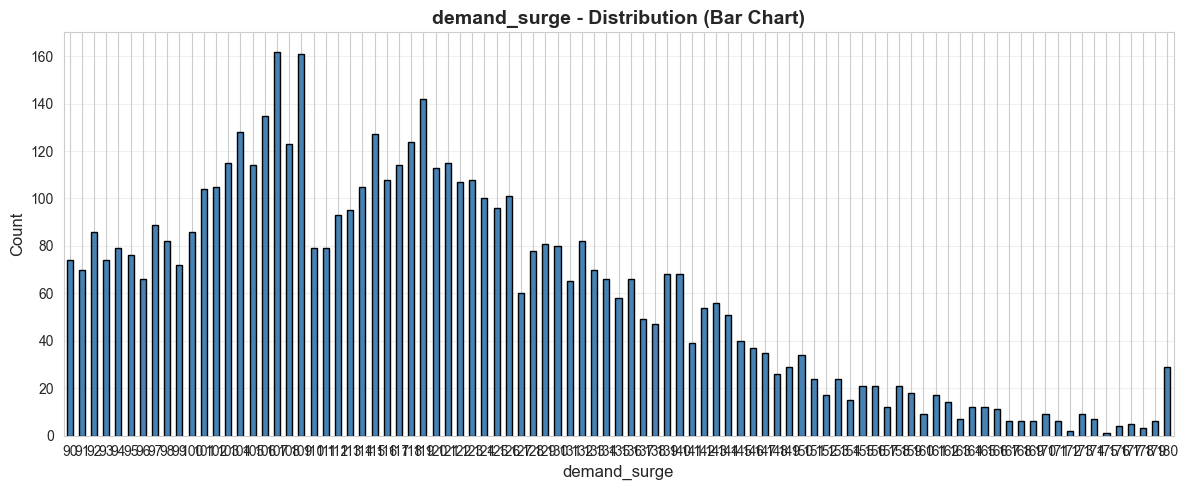

In [8]:
print("="*80)
print("TARGET VARIABLE ANALYSIS")
print("="*80)

print(f"\nTarget Variable: {target_col}")
print(f"Data Type: {df[target_col].dtype}")
print(f"\nUnique Values: {df[target_col].nunique()}")
print(f"\nValue Counts:")
print(df[target_col].value_counts().sort_index())

print("\n" + "="*80)
print("TARGET DISTRIBUTION")
print("="*80)

plt.figure(figsize=(12, 5))

df[target_col].value_counts().sort_index().plot(kind='bar', color='steelblue', edgecolor='black')
plt.title(f'{target_col} - Distribution (Bar Chart)', fontsize=14, fontweight='bold')
plt.xlabel(target_col, fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


NUMERICAL FEATURES - DISTRIBUTION ANALYSIS


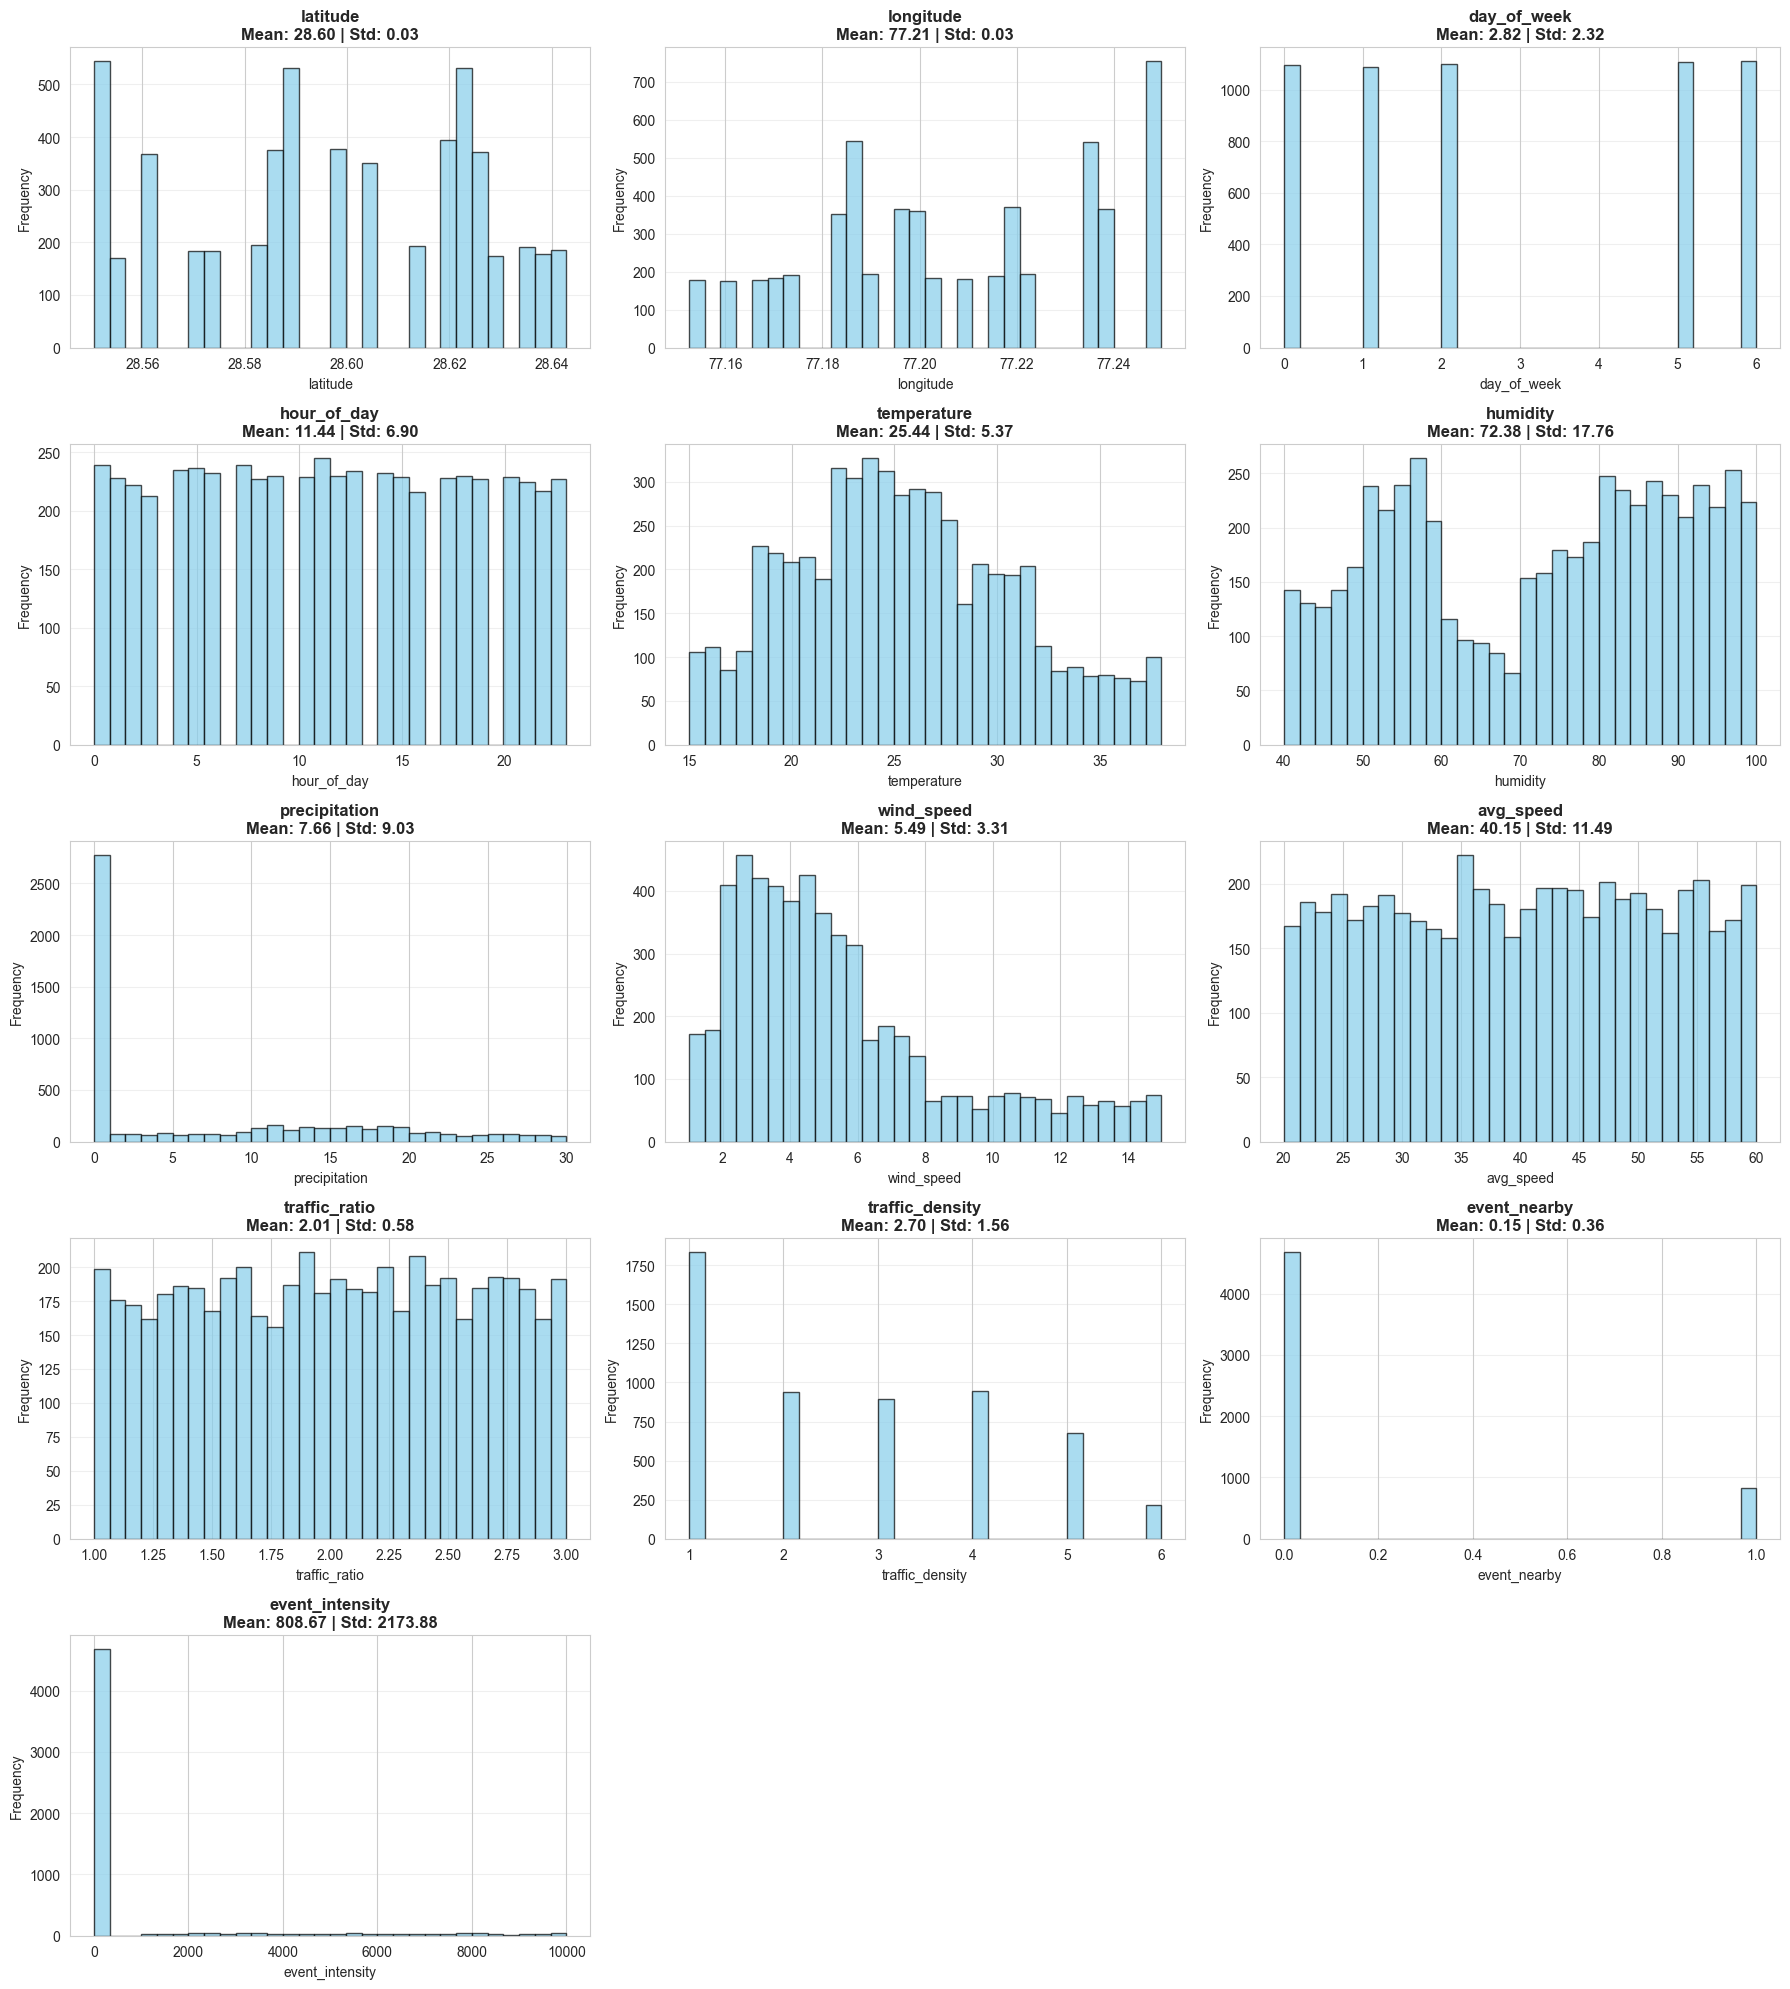

In [9]:
print("="*80)
print("NUMERICAL FEATURES - DISTRIBUTION ANALYSIS")
print("="*80)

# Plot distributions
num_plots = len(numerical_cols)
num_rows = (num_plots + 2) // 3
fig, axes = plt.subplots(num_rows, 3, figsize=(18, num_rows * 4))
axes = axes.flatten() if num_plots > 1 else [axes]

for idx, col in enumerate(numerical_cols):
    axes[idx].hist(df[col], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{col}\nMean: {df[col].mean():.2f} | Std: {df[col].std():.2f}', fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(axis='y', alpha=0.3)

# Remove empty subplots
for idx in range(num_plots, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

CORRELATION ANALYSIS

Correlation with Target Variable:
demand_surge       1.000000
event_nearby       0.549021
event_intensity    0.484804
day_of_week        0.349974
humidity           0.215055
hour_of_day        0.145734
precipitation      0.075984
avg_speed          0.008209
longitude          0.002933
traffic_ratio     -0.004571
traffic_density   -0.009791
latitude          -0.028459
wind_speed        -0.039061
temperature       -0.140107
Name: demand_surge, dtype: float64


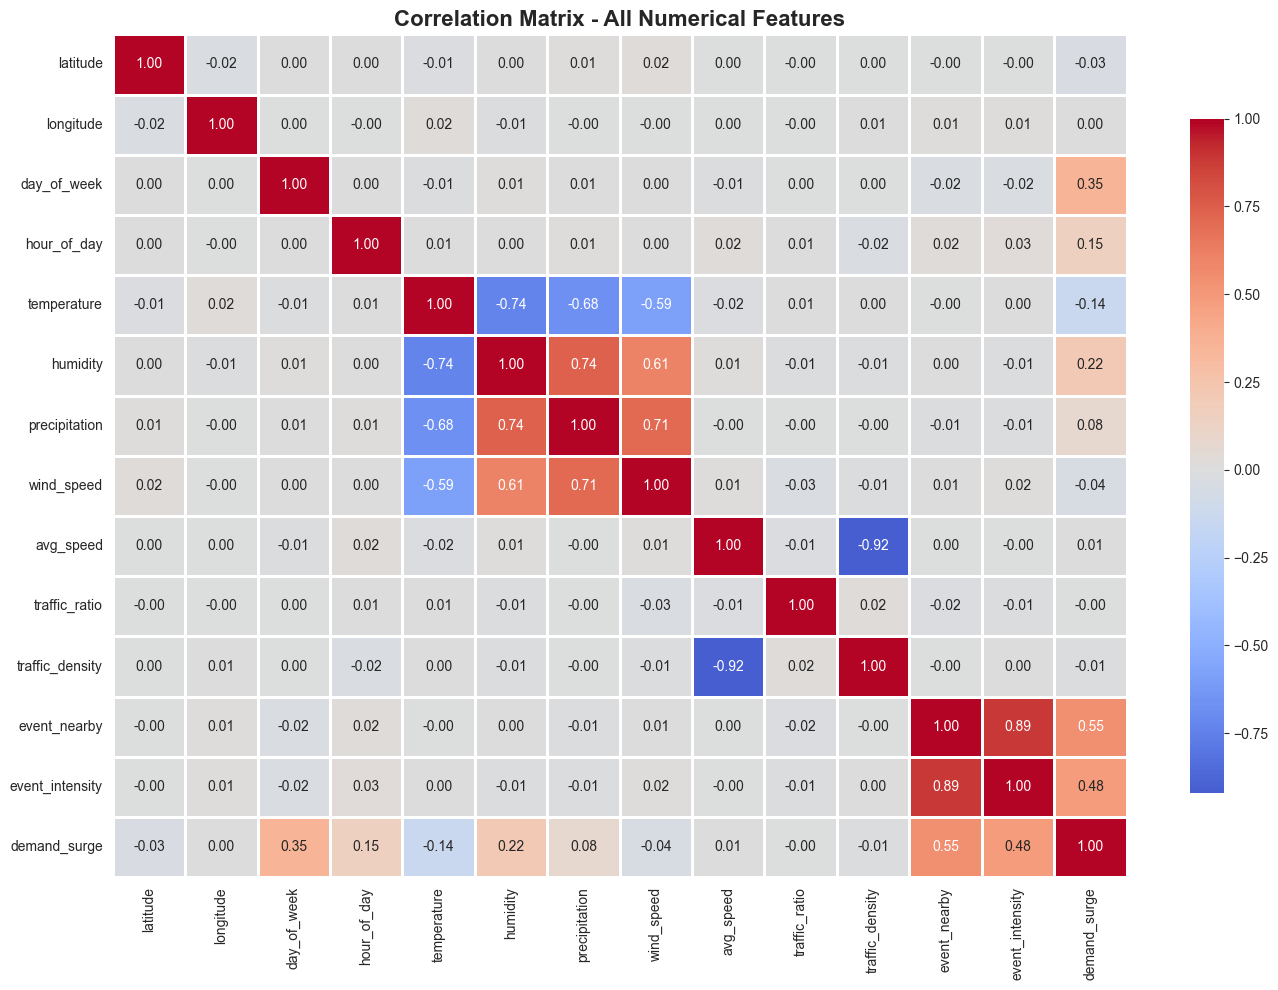


TOP FEATURES CORRELATED WITH TARGET
event_nearby       0.549021
event_intensity    0.484804
day_of_week        0.349974
humidity           0.215055
hour_of_day        0.145734
precipitation      0.075984
avg_speed          0.008209
longitude          0.002933
traffic_ratio     -0.004571
traffic_density   -0.009791
Name: demand_surge, dtype: float64


In [10]:
print("="*80)
print("CORRELATION ANALYSIS")
print("="*80)

# Calculate correlation matrix
correlation_matrix = df[numerical_cols + [target_col]].corr()

print("\nCorrelation with Target Variable:")
target_correlation = correlation_matrix[target_col].sort_values(ascending=False)
print(target_correlation)

# Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - All Numerical Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Top correlations with target
print("\n" + "="*80)
print("TOP FEATURES CORRELATED WITH TARGET")
print("="*80)
top_corr = target_correlation.drop(target_col).head(10)
print(top_corr)

OUTLIER DETECTION - BOX PLOTS


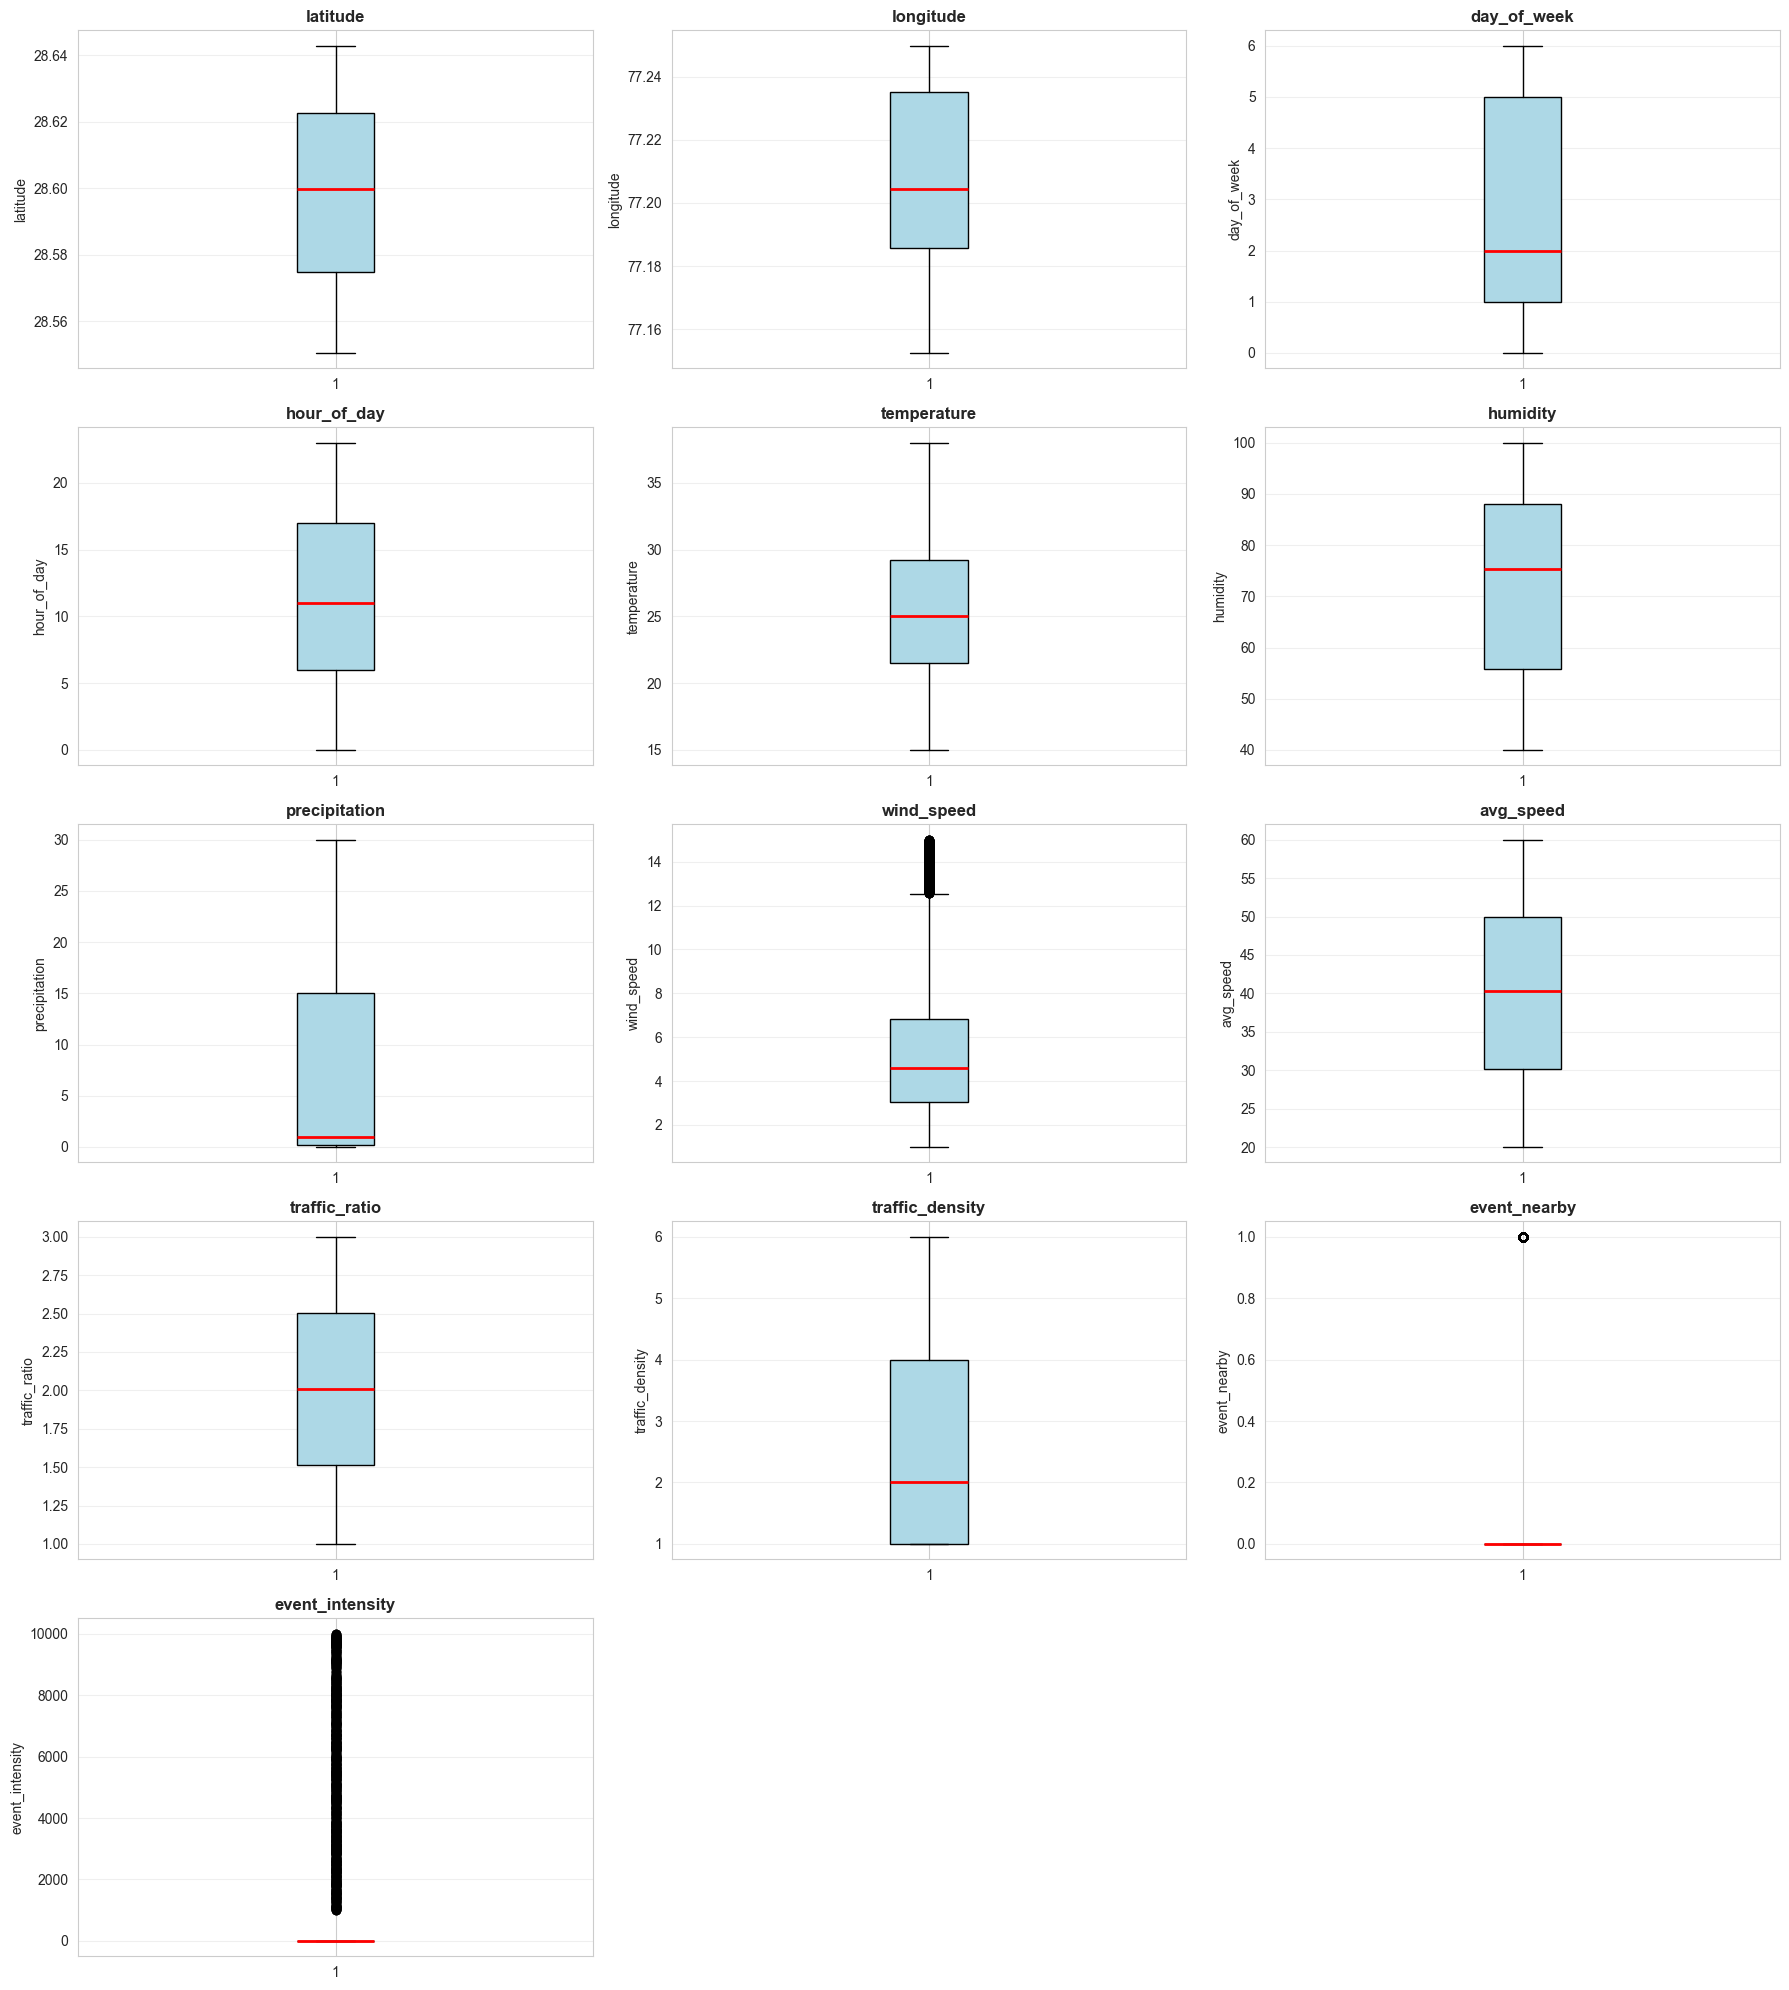


OUTLIER COUNTS (IQR Method)
latitude: 0 outliers (0.00%)
longitude: 0 outliers (0.00%)
day_of_week: 0 outliers (0.00%)
hour_of_day: 0 outliers (0.00%)
temperature: 0 outliers (0.00%)
humidity: 0 outliers (0.00%)
precipitation: 0 outliers (0.00%)
wind_speed: 334 outliers (6.07%)
avg_speed: 0 outliers (0.00%)
traffic_ratio: 0 outliers (0.00%)
traffic_density: 0 outliers (0.00%)
event_nearby: 824 outliers (14.98%)
event_intensity: 824 outliers (14.98%)


In [11]:
print("="*80)
print("OUTLIER DETECTION - BOX PLOTS")
print("="*80)

num_plots = len(numerical_cols)
num_rows = (num_plots + 2) // 3
fig, axes = plt.subplots(num_rows, 3, figsize=(18, num_rows * 4))
axes = axes.flatten() if num_plots > 1 else [axes]

for idx, col in enumerate(numerical_cols):
    axes[idx].boxplot(df[col].dropna(), vert=True, patch_artist=True,
                     boxprops=dict(facecolor='lightblue', color='black'),
                     medianprops=dict(color='red', linewidth=2))
    axes[idx].set_title(f'{col}', fontweight='bold')
    axes[idx].set_ylabel(col)
    axes[idx].grid(axis='y', alpha=0.3)

for idx in range(num_plots, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# IQR method for outlier detection
print("\n" + "="*80)
print("OUTLIER COUNTS (IQR Method)")
print("="*80)

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_count = len(outliers)
    outlier_percentage = (outlier_count / len(df)) * 100
    
    print(f"{col}: {outlier_count} outliers ({outlier_percentage:.2f}%)")

In [12]:
df_fe = df.copy()

In [13]:
print(f"\nOriginal dataset shape: {df.shape}")
print(f"Original columns: {df.columns.tolist()}")


Original dataset shape: (5500, 18)
Original columns: ['zone_id', 'latitude', 'longitude', 'datetime', 'day_of_week', 'hour_of_day', 'temperature', 'humidity', 'precipitation', 'wind_speed', 'weather_condition', 'avg_speed', 'traffic_ratio', 'traffic_density', 'event_nearby', 'event_type', 'event_intensity', 'demand_surge']


In [14]:
columns_to_drop = []

# 1.1 Drop zone_id (training-specific, not available during prediction)
if 'zone_id' in df_fe.columns:
    columns_to_drop.append('zone_id')
    print("Marking 'zone_id' for removal (training-specific identifier)")

# 1.2 Drop datetime (already extracted day_of_week and hour_of_day)
if 'datetime' in df_fe.columns:
    columns_to_drop.append('datetime')
    print("Marking 'datetime' for removal (features already extracted)")

# Drop all marked columns
if columns_to_drop:
    df_fe = df_fe.drop(columns=columns_to_drop, axis=1)
    print(f"\nDropped {len(columns_to_drop)} columns: {columns_to_drop}")
    print(f"New shape: {df_fe.shape}")


Marking 'zone_id' for removal (training-specific identifier)
Marking 'datetime' for removal (features already extracted)

Dropped 2 columns: ['zone_id', 'datetime']
New shape: (5500, 16)


In [15]:
correlated_features_to_drop = []

# 2.1 Drop traffic_density (highly correlated with avg_speed: -0.92)
if 'traffic_density' in df_fe.columns:
    correlated_features_to_drop.append('traffic_density')
    print("Marking 'traffic_density' for removal")
    print("Reason: -0.92 correlation with 'avg_speed'")

# 2.2 Drop event_intensity (highly correlated with event_nearby: 0.89)
if 'event_intensity' in df_fe.columns:
    correlated_features_to_drop.append('event_intensity')
    print("Marking 'event_intensity' for removal")
    print("Reason: 0.89 correlation with 'event_nearby'")

# 2.3 Drop wind_speed (correlated with precipitation: 0.71 and humidity: 0.61)
if 'wind_speed' in df_fe.columns:
    correlated_features_to_drop.append('wind_speed')
    print("Marking 'wind_speed' for removal")
    print("Reason: 0.71 correlation with 'precipitation', 0.61 with 'humidity'")

# Drop all correlated features
if correlated_features_to_drop:
    df_fe = df_fe.drop(columns=correlated_features_to_drop, axis=1)
    print(f"\nDropped {len(correlated_features_to_drop)} correlated features")
    print(f"New shape: {df_fe.shape}")


Marking 'traffic_density' for removal
Reason: -0.92 correlation with 'avg_speed'
Marking 'event_intensity' for removal
Reason: 0.89 correlation with 'event_nearby'
Marking 'wind_speed' for removal
Reason: 0.71 correlation with 'precipitation', 0.61 with 'humidity'

Dropped 3 correlated features
New shape: (5500, 13)


In [16]:
# Check for missing values
missing_summary = df_fe.isnull().sum()
missing_cols = missing_summary[missing_summary > 0]

if len(missing_cols) > 0:
    print(f"\nFound missing values in {len(missing_cols)} columns:")
    for col in missing_cols.index:
        missing_count = missing_cols[col]
        missing_pct = (missing_count / len(df_fe)) * 100
        print(f"   - {col}: {missing_count} ({missing_pct:.2f}%)")
    
    # Handle event_type missing values
    if 'event_type' in missing_cols.index:
        missing_event_count = df_fe['event_type'].isnull().sum()
        df_fe['event_type'] = df_fe['event_type'].fillna('No_Event')
        print(f"\nFilled {missing_event_count} missing 'event_type' values with 'No_Event'")
        print("Reason: Missing means no event is happening")
    
    # Check if any other missing values remain
    remaining_missing = df_fe.isnull().sum().sum()
    if remaining_missing > 0:
        print(f"\nWarning: {remaining_missing} missing values still remain")
        print("Columns with missing values:")
        print(df_fe.isnull().sum()[df_fe.isnull().sum() > 0])
else:
    print("No missing values found!")



Found missing values in 1 columns:
   - event_type: 4676 (85.02%)

Filled 4676 missing 'event_type' values with 'No_Event'
Reason: Missing means no event is happening


In [17]:
# 4.1 Log transform precipitation (heavily right-skewed)
if 'precipitation' in df_fe.columns:
    print("\nPrecipitation Statistics BEFORE transformation:")
    print(f"   Min: {df_fe['precipitation'].min():.2f}")
    print(f"   Max: {df_fe['precipitation'].max():.2f}")
    print(f"   Mean: {df_fe['precipitation'].mean():.2f}")
    print(f"   Median: {df_fe['precipitation'].median():.2f}")
    print(f"   Skewness: {df_fe['precipitation'].skew():.2f}")
    
    # Apply log1p transformation (log(1+x) to handle zeros)
    df_fe['precipitation_log'] = np.log1p(df_fe['precipitation'])
    df_fe = df_fe.drop('precipitation', axis=1)
    
    print("\nApplied log1p transformation: precipitation → precipitation_log")
    print(f"Precipitation_log Statistics AFTER transformation:")
    print(f"   Min: {df_fe['precipitation_log'].min():.2f}")
    print(f"   Max: {df_fe['precipitation_log'].max():.2f}")
    print(f"   Mean: {df_fe['precipitation_log'].mean():.2f}")
    print(f"   Median: {df_fe['precipitation_log'].median():.2f}")
    print(f"   Skewness: {df_fe['precipitation_log'].skew():.2f}")


Precipitation Statistics BEFORE transformation:
   Min: 0.00
   Max: 29.99
   Mean: 7.66
   Median: 0.99
   Skewness: 0.83

Applied log1p transformation: precipitation → precipitation_log
Precipitation_log Statistics AFTER transformation:
   Min: 0.00
   Max: 3.43
   Mean: 1.43
   Median: 0.69
   Skewness: 0.22


In [18]:
# 5.1 Peak Hour Indicator (7-10 AM or 5-8 PM)
if 'hour_of_day' in df_fe.columns:
    df_fe['is_peak_hour'] = (((df_fe['hour_of_day'] >= 7) & (df_fe['hour_of_day'] <= 10)) | 
                              ((df_fe['hour_of_day'] >= 17) & (df_fe['hour_of_day'] <= 20))).astype(int)
    peak_count = df_fe['is_peak_hour'].sum()
    peak_pct = (peak_count / len(df_fe)) * 100
    print(f"Created 'is_peak_hour' (7-10 AM or 5-8 PM)")
    print(f"Peak hours: {peak_count} records ({peak_pct:.1f}%)")

# 5.2 Weekend Indicator
if 'day_of_week' in df_fe.columns:
    df_fe['is_weekend'] = (df_fe['day_of_week'] >= 5).astype(int)
    weekend_count = df_fe['is_weekend'].sum()
    weekend_pct = (weekend_count / len(df_fe)) * 100
    print(f"Created 'is_weekend' (Saturday=5, Sunday=6)")
    print(f"Weekend records: {weekend_count} ({weekend_pct:.1f}%)")

# 5.3 Time Period Categories
if 'hour_of_day' in df_fe.columns:
    def categorize_hour(hour):
        if 0 <= hour < 6:
            return 'Night'
        elif 6 <= hour < 12:
            return 'Morning'
        elif 12 <= hour < 18:
            return 'Afternoon'
        else:
            return 'Evening'
    
    df_fe['time_period'] = df_fe['hour_of_day'].apply(categorize_hour)
    print(f"Created 'time_period' (Night/Morning/Afternoon/Evening)")
    print(f"Distribution:")
    time_dist = df_fe['time_period'].value_counts()
    for period, count in time_dist.items():
        print(f"   - {period}: {count} ({count/len(df_fe)*100:.1f}%)")

Created 'is_peak_hour' (7-10 AM or 5-8 PM)
Peak hours: 1839 records (33.4%)
Created 'is_weekend' (Saturday=5, Sunday=6)
Weekend records: 2219 (40.3%)
Created 'time_period' (Night/Morning/Afternoon/Evening)
Distribution:
   - Morning: 1402 (25.5%)
   - Night: 1374 (25.0%)
   - Afternoon: 1369 (24.9%)
   - Evening: 1355 (24.6%)


In [19]:
# 6.1 Weather Severity Score (ordinal encoding)
if 'weather_condition' in df_fe.columns:
    weather_severity_map = {'Clear': 1, 'Clouds': 2, 'Rain': 3, 'Storm': 4}
    df_fe['weather_severity_score'] = df_fe['weather_condition'].map(weather_severity_map)
    print(f"Created 'weather_severity_score' (Clear=1, Clouds=2, Rain=3, Storm=4)")
    print(f"Distribution:")
    for condition, score in weather_severity_map.items():
        count = (df_fe['weather_severity_score'] == score).sum()
        print(f"   - {condition} (score={score}): {count} ({count/len(df_fe)*100:.1f}%)")

# 6.2 Temperature-Humidity Interaction
if 'temperature' in df_fe.columns and 'humidity' in df_fe.columns:
    df_fe['temp_humidity_interaction'] = (df_fe['temperature'] * df_fe['humidity']) / 100
    print(f"Created 'temp_humidity_interaction' (temperature × humidity / 100)")
    print(f"Range: {df_fe['temp_humidity_interaction'].min():.2f} to {df_fe['temp_humidity_interaction'].max():.2f}")


Created 'weather_severity_score' (Clear=1, Clouds=2, Rain=3, Storm=4)
Distribution:
   - Clear (score=1): 1382 (25.1%)
   - Clouds (score=2): 1390 (25.3%)
   - Rain (score=3): 1337 (24.3%)
   - Storm (score=4): 1391 (25.3%)
Created 'temp_humidity_interaction' (temperature × humidity / 100)
Range: 10.13 to 27.65


In [20]:
if 'traffic_ratio' in df_fe.columns and 'humidity' in df_fe.columns:
    df_fe['traffic_weather_interaction'] = (df_fe['traffic_ratio'] * df_fe['humidity']) / 100
    print(f"Created 'traffic_weather_interaction' (traffic_ratio × humidity / 100)")
    print(f"Range: {df_fe['traffic_weather_interaction'].min():.2f} to {df_fe['traffic_weather_interaction'].max():.2f}")


Created 'traffic_weather_interaction' (traffic_ratio × humidity / 100)
Range: 0.40 to 2.95


In [21]:
if 'event_nearby' in df_fe.columns:
    df_fe['has_event'] = (df_fe['event_nearby'] > 0).astype(int)
    event_count = df_fe['has_event'].sum()
    event_pct = (event_count / len(df_fe)) * 100
    print(f"Created 'has_event' (1 if any event nearby, else 0)")
    print(f"Records with events: {event_count} ({event_pct:.1f}%)")

# 8.2 Event-Peak Hour Combination
if 'event_nearby' in df_fe.columns and 'is_peak_hour' in df_fe.columns:
    df_fe['event_peak_combo'] = df_fe['event_nearby'] * df_fe['is_peak_hour']
    combo_count = (df_fe['event_peak_combo'] > 0).sum()
    combo_pct = (combo_count / len(df_fe)) * 100
    print(f"Created 'event_peak_combo' (event_nearby × is_peak_hour)")
    print(f"Records with events during peak hours: {combo_count} ({combo_pct:.1f}%)")


Created 'has_event' (1 if any event nearby, else 0)
Records with events: 824 (15.0%)
Created 'event_peak_combo' (event_nearby × is_peak_hour)
Records with events during peak hours: 281 (5.1%)


In [22]:
print(f"\nSUMMARY:")
print(f"   Original dataset shape: {df.shape}")
print(f"   Final dataset shape: {df_fe.shape}")
print(f"   Features removed: {len(columns_to_drop) + len(correlated_features_to_drop)}")
print(f"   Features added: {df_fe.shape[1] - df.shape[1] + len(columns_to_drop) + len(correlated_features_to_drop)}")

# Separate features and target
target_col = 'demand_surge'
feature_cols = [col for col in df_fe.columns if col != target_col]


SUMMARY:
   Original dataset shape: (5500, 18)
   Final dataset shape: (5500, 21)
   Features removed: 5
   Features added: 8


In [23]:
numerical_features = df_fe[feature_cols].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df_fe[feature_cols].select_dtypes(include=['object']).columns.tolist()

print(f"\nNUMERICAL FEATURES ({len(numerical_features)}):")
for idx, col in enumerate(numerical_features, 1):
    print(f"   {idx:2d}. {col}")

print(f"\nCATEGORICAL FEATURES ({len(categorical_features)}):")
for idx, col in enumerate(categorical_features, 1):
    print(f"   {idx:2d}. {col}")

print(f"\nTARGET VARIABLE: {target_col}")



NUMERICAL FEATURES (17):
    1. latitude
    2. longitude
    3. day_of_week
    4. hour_of_day
    5. temperature
    6. humidity
    7. avg_speed
    8. traffic_ratio
    9. event_nearby
   10. precipitation_log
   11. is_peak_hour
   12. is_weekend
   13. weather_severity_score
   14. temp_humidity_interaction
   15. traffic_weather_interaction
   16. has_event
   17. event_peak_combo

CATEGORICAL FEATURES (3):
    1. weather_condition
    2. event_type
    3. time_period

TARGET VARIABLE: demand_surge


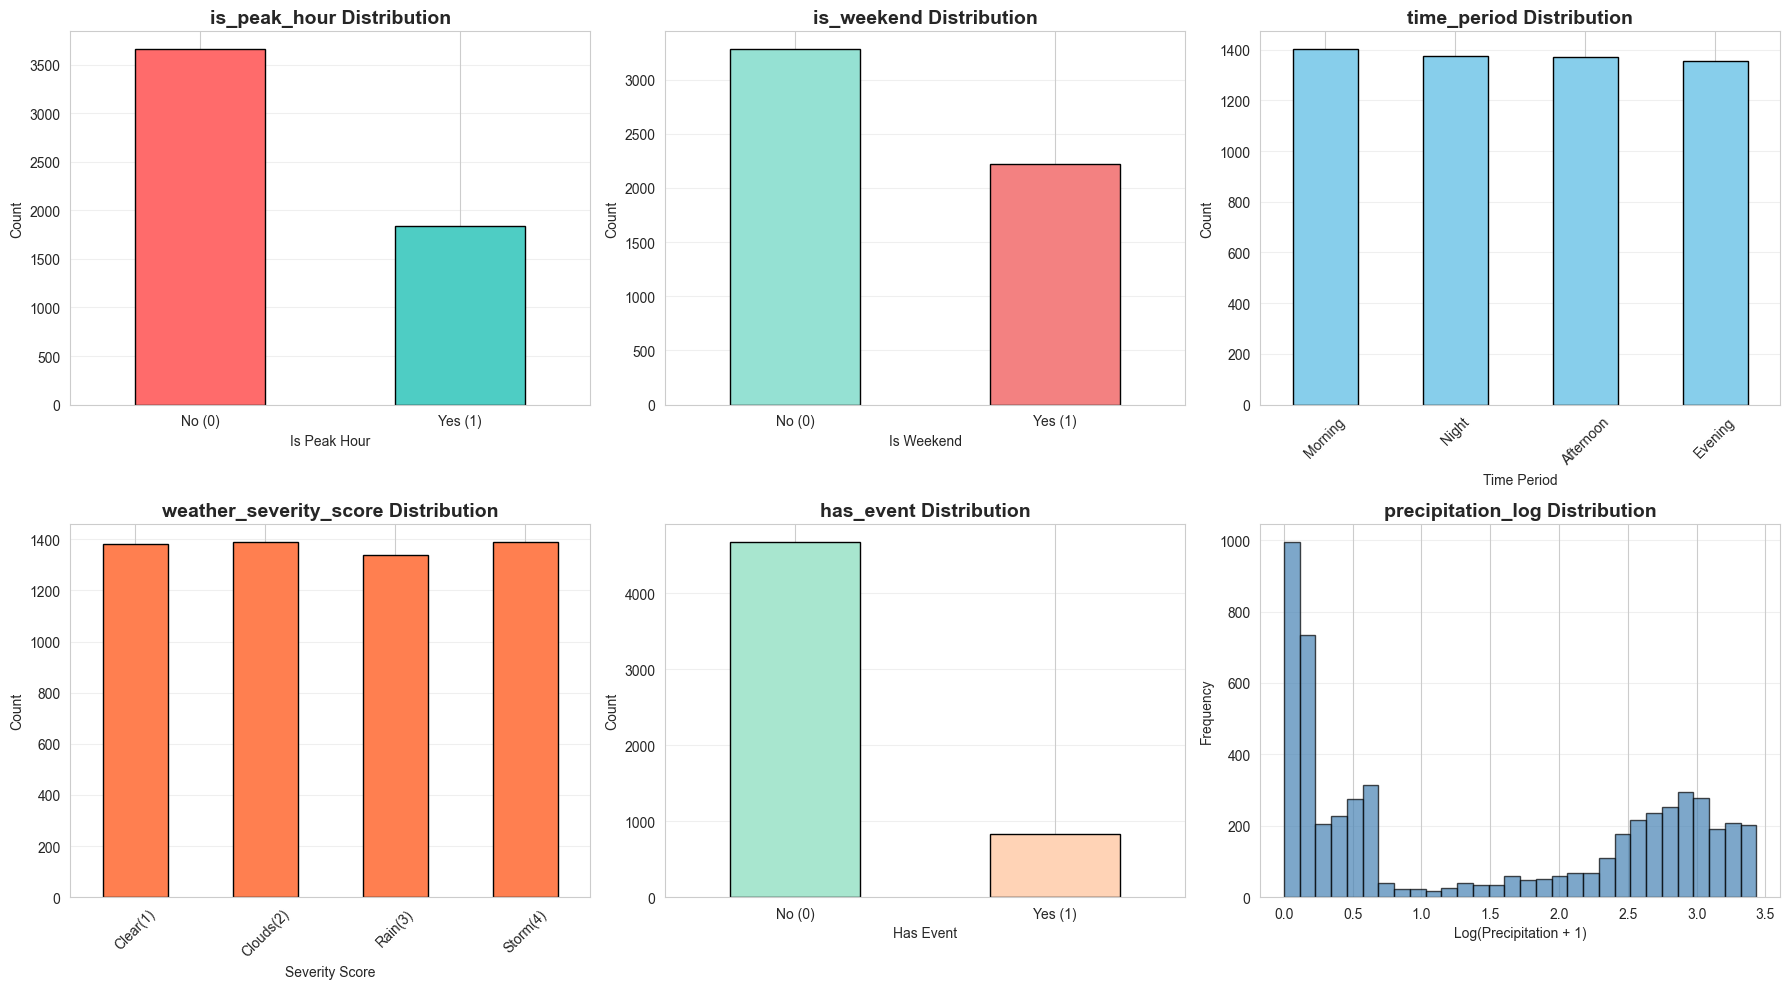

In [24]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. is_peak_hour distribution
df_fe['is_peak_hour'].value_counts().plot(kind='bar', ax=axes[0, 0], color=['#FF6B6B', '#4ECDC4'], edgecolor='black')
axes[0, 0].set_title('is_peak_hour Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Is Peak Hour')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_xticklabels(['No (0)', 'Yes (1)'], rotation=0)
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. is_weekend distribution
df_fe['is_weekend'].value_counts().plot(kind='bar', ax=axes[0, 1], color=['#95E1D3', '#F38181'], edgecolor='black')
axes[0, 1].set_title('is_weekend Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Is Weekend')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_xticklabels(['No (0)', 'Yes (1)'], rotation=0)
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. time_period distribution
df_fe['time_period'].value_counts().plot(kind='bar', ax=axes[0, 2], color='skyblue', edgecolor='black')
axes[0, 2].set_title('time_period Distribution', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Time Period')
axes[0, 2].set_ylabel('Count')
axes[0, 2].tick_params(axis='x', rotation=45)
axes[0, 2].grid(axis='y', alpha=0.3)

# 4. weather_severity_score distribution
df_fe['weather_severity_score'].value_counts().sort_index().plot(kind='bar', ax=axes[1, 0], color='coral', edgecolor='black')
axes[1, 0].set_title('weather_severity_score Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Severity Score')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_xticklabels(['Clear(1)', 'Clouds(2)', 'Rain(3)', 'Storm(4)'], rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# 5. has_event distribution
df_fe['has_event'].value_counts().plot(kind='bar', ax=axes[1, 1], color=['#A8E6CF', '#FFD3B6'], edgecolor='black')
axes[1, 1].set_title('has_event Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Has Event')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_xticklabels(['No (0)', 'Yes (1)'], rotation=0)
axes[1, 1].grid(axis='y', alpha=0.3)

# 6. precipitation_log distribution
axes[1, 2].hist(df_fe['precipitation_log'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[1, 2].set_title('precipitation_log Distribution', fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel('Log(Precipitation + 1)')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


Top 15 Features Correlated with Target:
--------------------------------------------------------------------------------
 1. event_nearby                        + 0.5490 ███████████████████████████
 2. has_event                           + 0.5490 ███████████████████████████
 3. event_peak_combo                    + 0.3872 ███████████████████
 4. is_weekend                          + 0.3669 ██████████████████
 5. day_of_week                         + 0.3500 █████████████████
 6. is_peak_hour                        + 0.2341 ███████████
 7. humidity                            + 0.2151 ██████████
 8. precipitation_log                   + 0.1891 █████████
 9. temp_humidity_interaction           + 0.1661 ████████
10. hour_of_day                         + 0.1457 ███████
11. weather_severity_score              + 0.1311 ██████
12. traffic_weather_interaction         + 0.1304 ██████
13. avg_speed                           + 0.0082 
14. longitude                           + 0.0029 
15. traffic_r

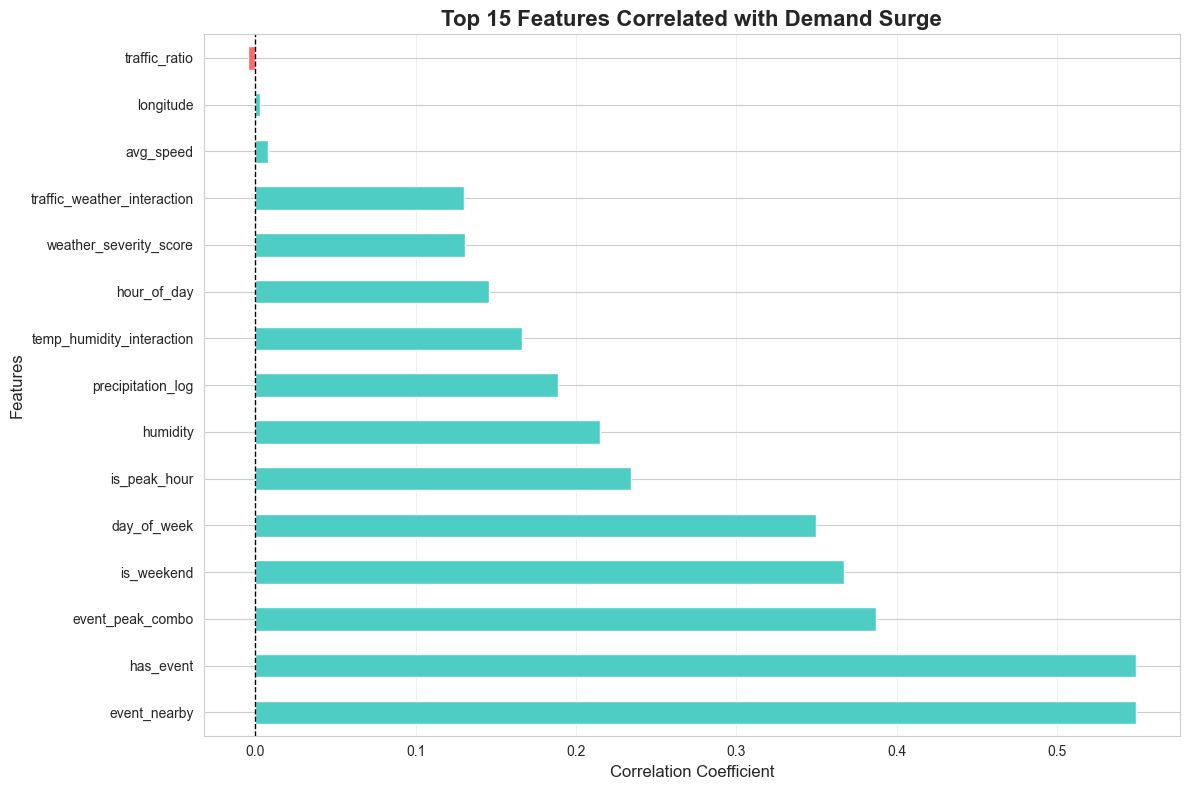

In [25]:
# Calculate correlation with target for numerical features
numerical_features_with_target = numerical_features + [target_col]
correlation_with_target = df_fe[numerical_features_with_target].corr()[target_col].sort_values(ascending=False)

print("\nTop 15 Features Correlated with Target:")
print("-" * 80)
top_15_corr = correlation_with_target.drop(target_col).head(15)
for idx, (feature, corr) in enumerate(top_15_corr.items(), 1):
    bar = '█' * int(abs(corr) * 50)
    sign = '+' if corr > 0 else '-'
    print(f"{idx:2d}. {feature:35s} {sign} {abs(corr):.4f} {bar}")

# Visualize top correlations
plt.figure(figsize=(12, 8))
top_15_corr.plot(kind='barh', color=top_15_corr.apply(lambda x: '#4ECDC4' if x > 0 else '#FF6B6B'))
plt.title('Top 15 Features Correlated with Demand Surge', fontsize=16, fontweight='bold')
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [26]:
# Separate features and target
target_col = 'demand_surge'
X = df_fe.drop(target_col, axis=1)
y = df_fe[target_col]


In [27]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")

Training set: (4400, 20)
Testing set: (1100, 20)


In [28]:
# Identify categorical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

# Create copies
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

# Encode categorical features
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X_train_encoded[col] = le.fit_transform(X_train_encoded[col].astype(str))
    
    # Transform test data (handle unseen categories)
    X_test_encoded[col] = X_test_encoded[col].astype(str).map(
        lambda x: le.transform([x])[0] if x in le.classes_ else -1
    )
    
    label_encoders[col] = le

print(f"Encoded {len(categorical_cols)} categorical features")

Encoded 3 categorical features


In [29]:
import pandas as pd

# Initialize scaler
scaler = StandardScaler()

# Fit on train, transform both
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_encoded.columns, index=X_train_encoded.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_encoded.columns, index=X_test_encoded.index)

print(f"Features scaled")
print(f"Train mean: {X_train_scaled.mean().mean():.6f}")
print(f"Train std: {X_train_scaled.std().mean():.6f}")

Features scaled
Train mean: 0.000000
Train std: 1.000114


In [30]:
# LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': 10,
    'min_child_samples': 20,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,
    'verbose': -1
}

# Create datasets with SCALED data
train_data = lgb.Dataset(X_train_scaled, label=y_train)
test_data = lgb.Dataset(X_test_scaled, label=y_test, reference=train_data)

# Train model
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

print(f"Best iteration: {model.best_iteration}")

Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 6.33634	valid's rmse: 7.27503
Early stopping, best iteration is:
[125]	train's rmse: 6.05525	valid's rmse: 7.22279
Best iteration: 125


In [31]:
# Make predictions
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"\nTraining Metrics:")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  MAE: {train_mae:.4f}")
print(f"  R²: {train_r2:.4f}")

print(f"\nTesting Metrics:")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  MAE: {test_mae:.4f}")
print(f"  R²: {test_r2:.4f}")


Training Metrics:
  RMSE: 6.0552
  MAE: 4.9961
  R²: 0.8943

Testing Metrics:
  RMSE: 7.2228
  MAE: 5.8015
  R²: 0.8562



Top 10 Important Features:
                   Feature    Importance
9             event_nearby  3.347606e+06
6        weather_condition  2.828526e+06
2              day_of_week  1.717257e+06
3              hour_of_day  1.385671e+06
12            is_peak_hour  4.734276e+05
18               has_event  4.088307e+05
15  weather_severity_score  2.541458e+05
11       precipitation_log  1.934445e+05
13              is_weekend  1.358862e+05
4              temperature  8.782515e+04


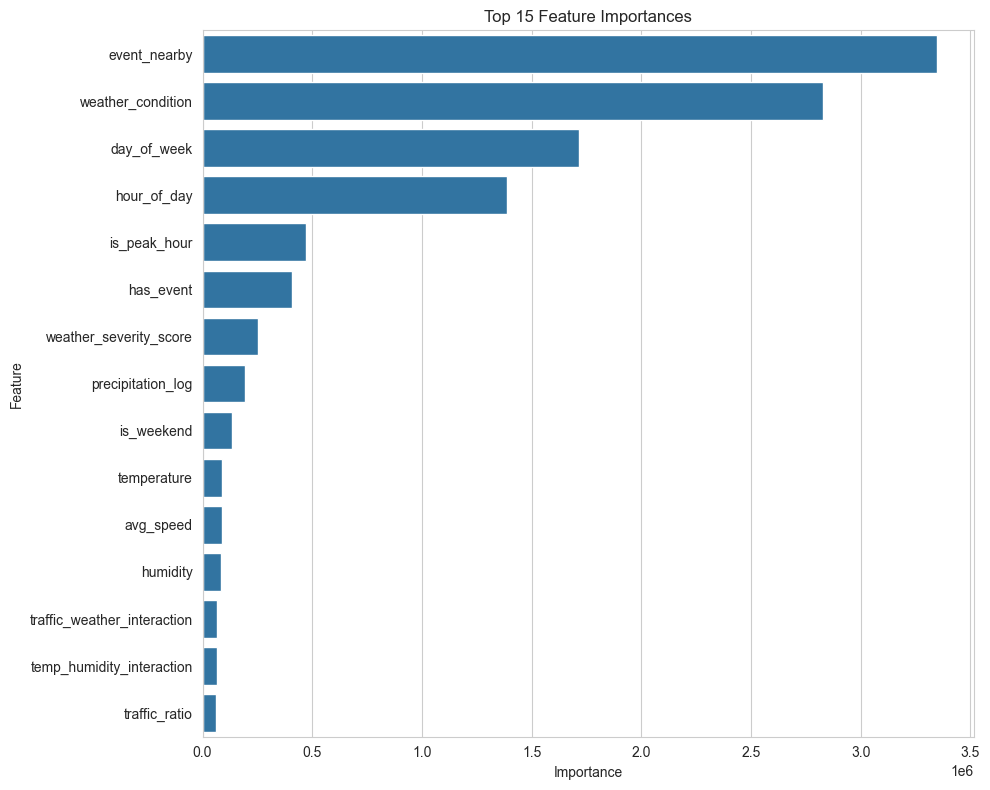

In [32]:
# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': model.feature_importance(importance_type='gain')
}).sort_values('Importance', ascending=False)

print("\nTop 10 Important Features:")
print(feature_importance.head(10))

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(15), x='Importance', y='Feature')
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

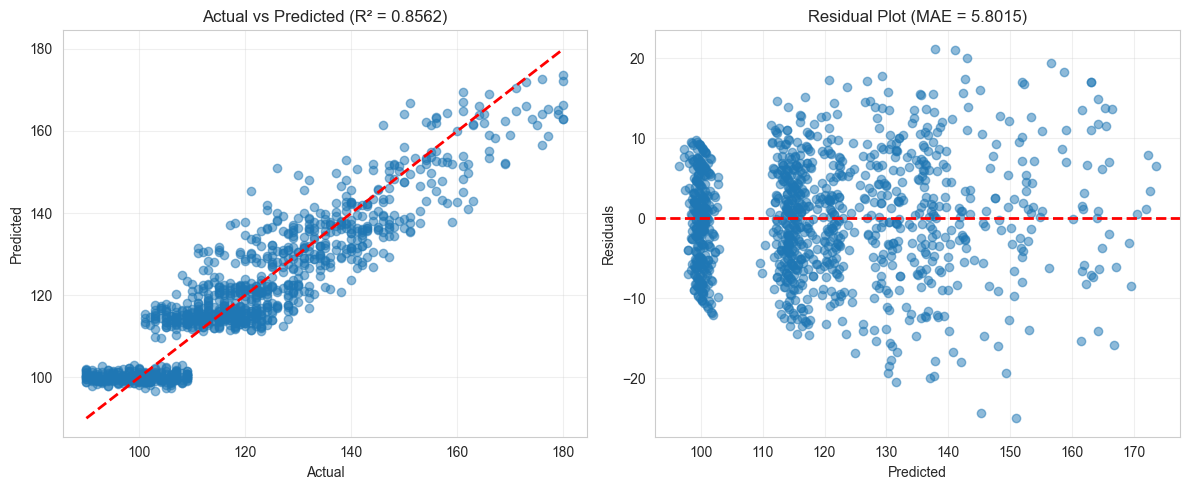

In [33]:
# Plot actual vs predicted
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Actual vs Predicted (R² = {test_r2:.4f})')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title(f'Residual Plot (MAE = {test_mae:.4f})')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [34]:
# Save model
model.save_model('lgbm_model.txt')
joblib.dump(model, 'lgbm_model.pkl')

# Save scaler
joblib.dump(scaler, 'scaler.pkl')

# Save encoders
joblib.dump(label_encoders, 'label_encoders.pkl')

# Save feature columns
feature_columns = X_train_scaled.columns.tolist()
joblib.dump(feature_columns, 'feature_columns.pkl')

# Save categorical columns
joblib.dump(categorical_cols, 'categorical_columns.pkl')


['categorical_columns.pkl']

In [35]:
# Load everything
loaded_model = lgb.Booster(model_file='lgbm_model.txt')
loaded_scaler = joblib.load('scaler.pkl')
loaded_encoders = joblib.load('label_encoders.pkl')

# Test on one sample (unscaled)
sample_original = X_test_encoded.iloc[0:1]
sample_scaled = loaded_scaler.transform(sample_original)

prediction = loaded_model.predict(sample_scaled)[0]
actual = y_test.iloc[0]

print(f"\nTest Prediction:")
print(f"  Actual: {actual:.2f}")
print(f"  Predicted: {prediction:.2f}")
print(f"  Error: {abs(actual - prediction):.2f}")


Test Prediction:
  Actual: 107.00
  Predicted: 100.71
  Error: 6.29


In [36]:
df_fe.columns

Index(['latitude', 'longitude', 'day_of_week', 'hour_of_day', 'temperature', 'humidity', 'weather_condition', 'avg_speed', 'traffic_ratio', 'event_nearby', 'event_type', 'demand_surge', 'precipitation_log', 'is_peak_hour', 'is_weekend', 'time_period', 'weather_severity_score', 'temp_humidity_interaction', 'traffic_weather_interaction', 'has_event', 'event_peak_combo'], dtype='object')